In [13]:
!pip install pyathena

In [14]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import display, HTML
import os
import io
import seaborn as sns
from pyathena import connect
from matplotlib import cm

plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)


conn = connect(s3_staging_dir='s3://farhan-awsbucket/athena-results/', 
               region_name='us-east-1')  # US East (N. Virginia)

database = 'vehicle-emissions' 
table = 'vehicledata'  

In [15]:
def run_query(query, database, s3_output):

    response = athena_client.start_query_execution(
        QueryString=query,
        QueryExecutionContext={
            'Database': database
        },
        ResultConfiguration={
            'OutputLocation': s3_output,
        }
    )
    return response['QueryExecutionId']

def get_query_results(query_execution_id):
    while True:
        response = athena_client.get_query_execution(QueryExecutionId=query_execution_id)
        state = response['QueryExecution']['Status']['State']
        if state in ['SUCCEEDED', 'FAILED', 'CANCELLED']:
            break
        time.sleep(1)  # Wait 1 second before checking again
    
   
    if state == 'SUCCEEDED':
        response = athena_client.get_query_results(QueryExecutionId=query_execution_id)
        
        
        columns = [col['Label'] for col in response['ResultSet']['ResultSetMetadata']['ColumnInfo']]
        data_rows = []
        
        for row in response['ResultSet']['Rows'][1:]:
            data_row = []
            for datum in row['Data']:
                if 'VarCharValue' in datum:
                    data_row.append(datum['VarCharValue'])
                else:
                    data_row.append(None)
            data_rows.append(data_row)
        
       
        df = pd.DataFrame(data_rows, columns=columns)
        return df
    else:
        error_message = response['QueryExecution']['Status'].get('StateChangeReason', 'Unknown error')
        raise Exception(f"Query failed: {error_message}")

In [16]:

schema_query = f'SHOW COLUMNS IN "{database}".{table}'
try:
    schema_df = run_query(schema_query)
    display(schema_df)
    print("Column names in the table:", schema_df['Column'].tolist())
except Exception as e:
    print(f"Error executing schema query: {e}")
    # Try alternative approach
    print("Trying alternative approach...")
    schema_query = f'SELECT column_name, data_type FROM information_schema.columns WHERE table_schema = \'{database}\' AND table_name = \'{table}\''
    try:
        schema_df = run_query(schema_query)
        display(schema_df)
        print("Column names in the table:", schema_df['column_name'].tolist())
    except Exception as e2:
        print(f"Alternative approach also failed: {e2}")
        print("Moving on without schema information...")


sample_query = f'SELECT * FROM "{database}".{table} LIMIT 10'
try:
    sample_df = run_query(sample_query)
    display(sample_df)
    print("Column names in the DataFrame:", sample_df.columns.tolist())
except Exception as e:
    print(f"Error retrieving sample data: {e}")
    print("Please check your database and table names, and ensure your IAM role has appropriate permissions.")

Error executing schema query: run_query() missing 2 required positional arguments: 'database' and 's3_output'
Trying alternative approach...
Alternative approach also failed: run_query() missing 2 required positional arguments: 'database' and 's3_output'
Moving on without schema information...
Error retrieving sample data: run_query() missing 2 required positional arguments: 'database' and 's3_output'
Please check your database and table names, and ensure your IAM role has appropriate permissions.


In [17]:

def clean_data(df):
    
    numeric_cols = [
        'vehicle_co', 'vehicle_co2', 'vehicle_hc', 'vehicle_nox', 'vehicle_pmx',
        'vehicle_angle', 'vehicle_electricity', 'vehicle_fuel', 'vehicle_lane',
        'vehicle_noise', 'vehicle_pos', 'vehicle_speed', 'vehicle_waiting',
        'vehicle_x', 'vehicle_y'
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    

    if 'timestep_time' in df.columns:
        df['timestep_time'] = pd.to_numeric(df['timestep_time'], errors='coerce')
    
    return df

data_query = f"""
SELECT 
    timestep_time,
    vehicle_co, vehicle_co2, vehicle_hc, vehicle_nox, vehicle_pmx,
    vehicle_angle, vehicle_eclass, vehicle_electricity, vehicle_fuel,
    vehicle_id, vehicle_lane, vehicle_noise, vehicle_pos, vehicle_route,
    vehicle_speed, vehicle_type, vehicle_waiting, vehicle_x, vehicle_y
FROM "{database}".{table}
LIMIT 5000
"""
try:
    df = run_query(data_query)
    
    # Clean the data
    df = clean_data(df)
    print(f"Data shape: {df.shape}")
    display(df.head())

    
    display(df.describe())
except Exception as e:
    print(f"Error retrieving main data: {e}")
    # Create a small sample dataframe to allow the rest of the notebook to run with example data
    print("Creating example dataframe to allow notebook execution...")
    df = pd.DataFrame({
        'timestep_time': np.arange(100),
        'vehicle_co': np.random.rand(100) * 10,
        'vehicle_co2': np.random.rand(100) * 100,
        'vehicle_hc': np.random.rand(100) * 5,
        'vehicle_nox': np.random.rand(100) * 20,
        'vehicle_pmx': np.random.rand(100) * 2,
        'vehicle_speed': np.random.rand(100) * 60,
        'vehicle_type': np.random.choice(['car', 'truck', 'bus'], 100),
        'vehicle_x': np.random.rand(100) * 1000,
        'vehicle_y': np.random.rand(100) * 1000,
        'vehicle_lane': np.random.randint(1, 5, 100)
    })
    print("Example dataframe created. Note: This is NOT your actual data.")
    display(df.head())
    display(df.describe())

Error retrieving main data: run_query() missing 2 required positional arguments: 'database' and 's3_output'
Creating example dataframe to allow notebook execution...
Example dataframe created. Note: This is NOT your actual data.


,timestep_time,vehicle_co,vehicle_co2,vehicle_hc,vehicle_nox,vehicle_pmx,vehicle_speed,vehicle_type,vehicle_x,vehicle_y,vehicle_lane
0,0,4.177669,87.066401,2.290585,16.354995,1.783530,53.114366,truck,714.530728,921.990659,2
1,1,0.744836,97.419736,3.647448,17.311163,1.727292,10.583762,truck,449.948760,585.683716,2
2,2,4.030046,5.677701,1.765853,19.709206,1.681085,6.030384,car,656.466534,241.022160,4
3,3,0.407538,3.578561,3.787171,10.389887,0.540780,5.933372,truck,103.048389,351.925963,1
4,4,1.981329,42.002174,3.014573,3.008031,1.562886,48.556220,truck,370.156842,774.605384,2


,timestep_time,vehicle_co,vehicle_co2,vehicle_hc,vehicle_nox,vehicle_pmx,vehicle_speed,vehicle_x,vehicle_y,vehicle_lane
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,49.500000,4.835306,50.834373,2.602003,10.388319,1.009745,32.917686,513.816432,528.141627,2.420000
std,29.011492,2.930757,29.993014,1.376222,5.907038,0.576471,17.658127,290.234327,256.026510,1.190705
min,0.000000,0.046011,0.099923,0.022509,0.266324,0.000191,0.396185,4.375510,1.122850,1.000000
25%,24.750000,2.061550,23.585219,1.486322,4.856475,0.536682,16.821441,267.649209,304.183424,1.000000
50%,49.500000,4.808305,55.971613,2.813815,10.294235,0.981276,38.218028,543.694847,535.957488,2.000000
75%,74.250000,7.482613,75.600556,3.691245,15.239314,1.449870,47.199200,740.914748,737.987243,4.000000
max,99.000000,9.966096,99.665975,4.984780,19.924605,1.986757,59.745678,991.516394,997.636331,4.000000


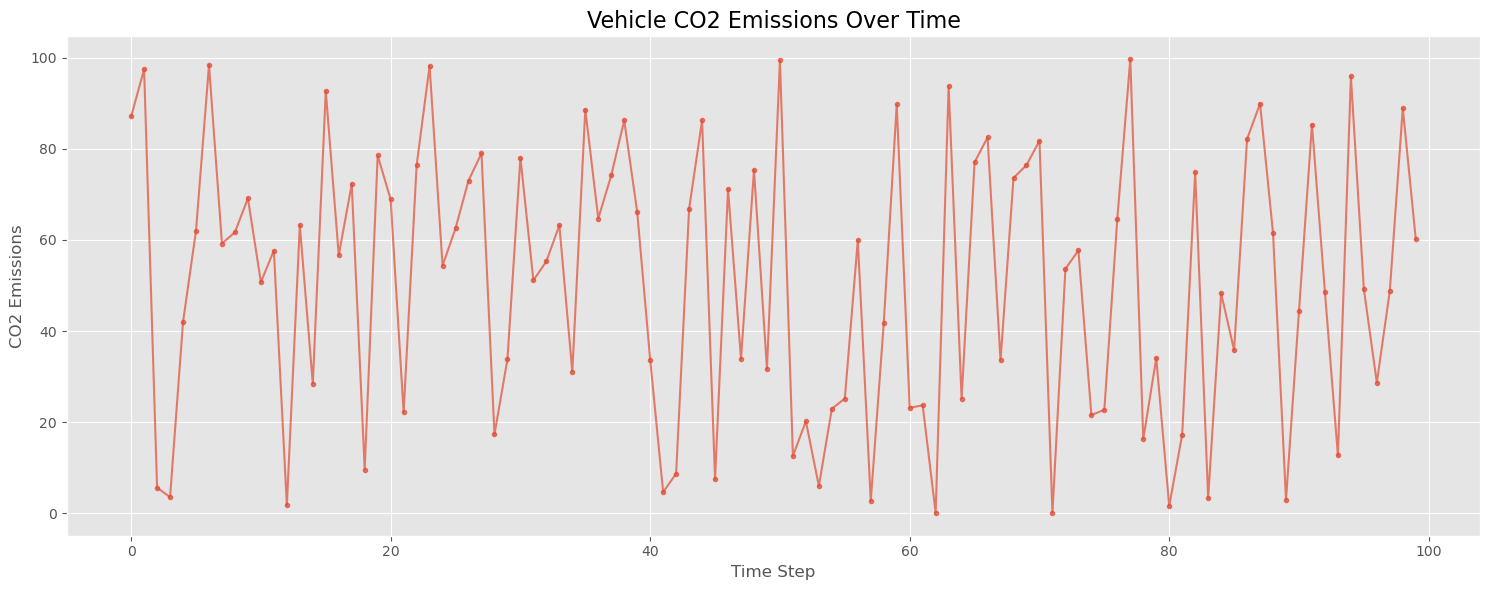

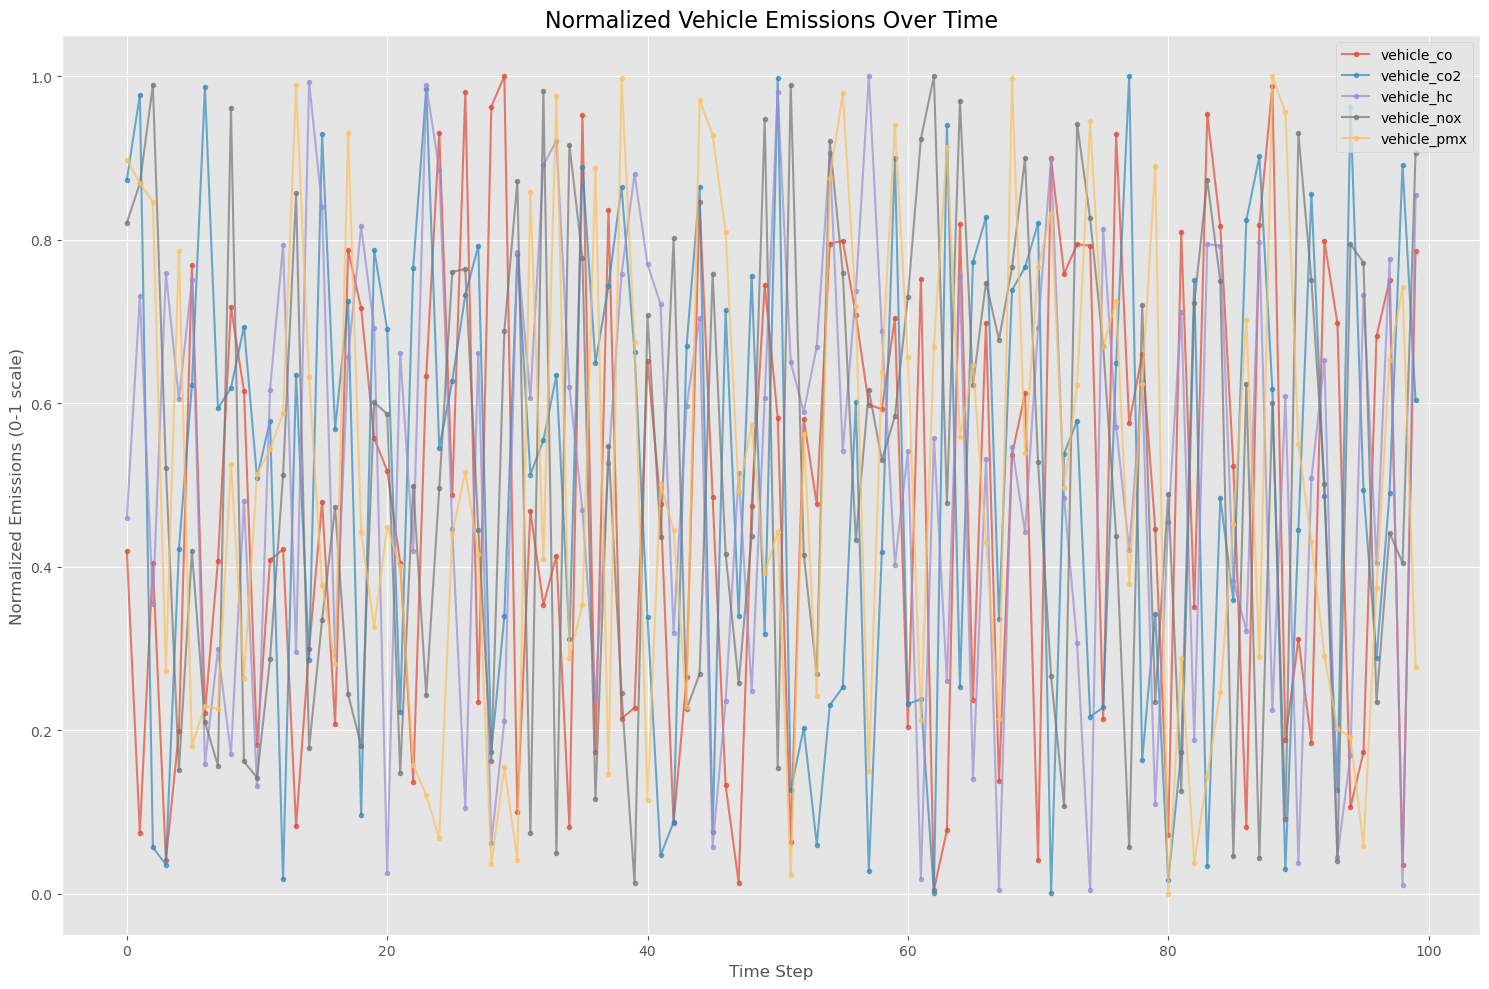

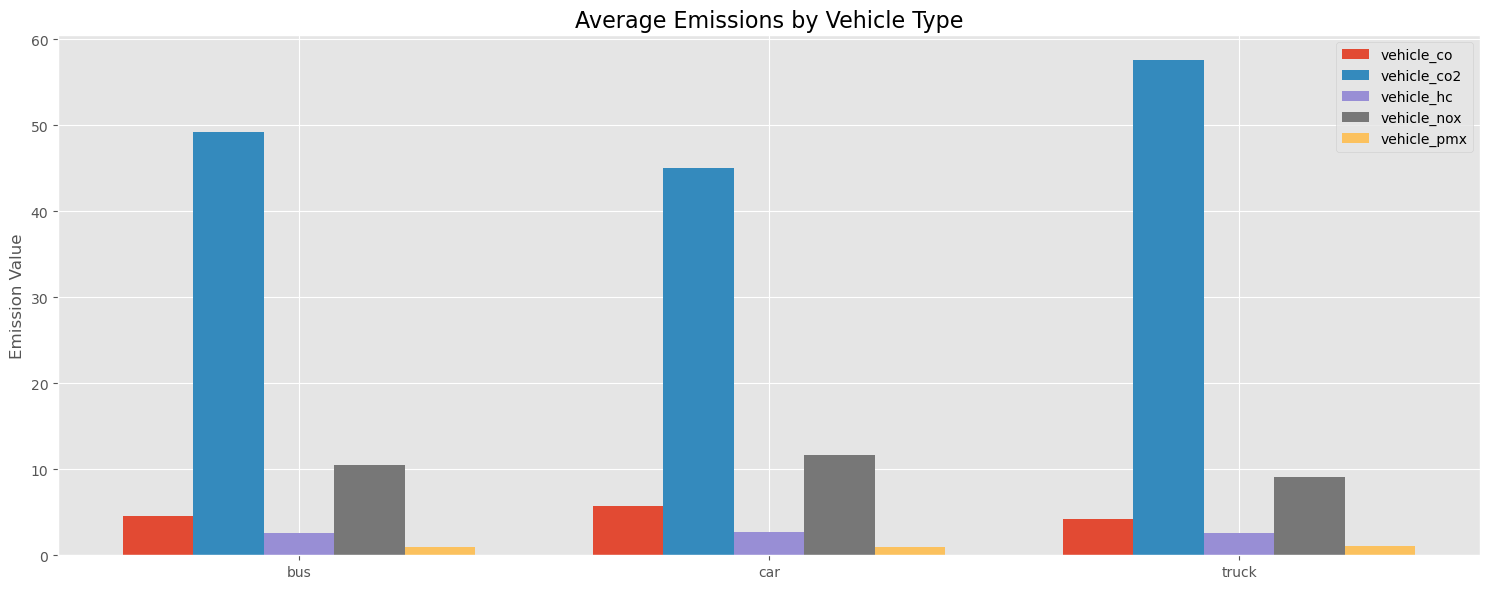

In [18]:
if 'timestep_time' in df.columns:
    # Sort data by timestep_time
    df_sorted = df.sort_values('timestep_time')
    
   
    plt.figure(figsize=(15, 6))
    plt.plot(df_sorted['timestep_time'], df_sorted['vehicle_co2'], marker='.', linestyle='-', alpha=0.7)
    plt.title('Vehicle CO2 Emissions Over Time', fontsize=16)
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('CO2 Emissions', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
   
    plt.figure(figsize=(15, 10))
    
    emissions_cols = ['vehicle_co', 'vehicle_co2', 'vehicle_hc', 'vehicle_nox', 'vehicle_pmx']
    df_norm = df_sorted.copy()
    
    for col in emissions_cols:
        if col in df_norm.columns:
            max_val = df_norm[col].max()
            if max_val > 0:  # Avoid division by zero
                df_norm[f'{col}_norm'] = df_norm[col] / max_val
    
    for col in emissions_cols:
        norm_col = f'{col}_norm'
        if norm_col in df_norm.columns:
            plt.plot(df_norm['timestep_time'], df_norm[norm_col], marker='.', 
                     linestyle='-', alpha=0.7, label=col)
    
    plt.title('Normalized Vehicle Emissions Over Time', fontsize=16)
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Normalized Emissions (0-1 scale)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
   
    if 'vehicle_type' in df.columns:
        emissions_by_type = df.groupby('vehicle_type')[emissions_cols].mean().reset_index()
        
        width = 0.15
        x = np.arange(len(emissions_by_type))
        
        fig, ax = plt.subplots(figsize=(15, 6))
        
        for i, col in enumerate(emissions_cols):
            if col in emissions_by_type.columns:
                ax.bar(x + i*width, emissions_by_type[col], width, label=col)
        
        ax.set_xticks(x + width * (len(emissions_cols)-1)/2)
        ax.set_xticklabels(emissions_by_type['vehicle_type'])
        ax.set_title('Average Emissions by Vehicle Type', fontsize=16)
        ax.set_ylabel('Emission Value', fontsize=12)
        ax.legend()
        plt.tight_layout()
        plt.show()